# Week 2 - In-Class Assignment 1 - Data Preprocessing

## Step 1: Handling Missing Values

The dataset used is the California housing dataset from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

The first step is to initialize the dataset and inject the missing values, due to the dataset not having missing values of itself.

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# Load dataset
data_bunch = fetch_california_housing(as_frame=True)
X_raw = data_bunch.data

# Reproducibility
np.random.seed(42)

# Inject missing values into 'HouseAge'
missing_mask = np.random.rand(len(X_raw)) < 0.1
X_raw.loc[missing_mask, "HouseAge"] = np.nan

print("Raw Data Sample:")
display(X_raw.head())

Raw Data Sample:


/var/folders/n6/lnwmrfbj22z5dwxf2j15l_xh0000gn/T/ipykernel_70277/3459870559.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_raw.loc[missing_mask, "HouseAge"] = np.nan


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


The next step is to identify the missing values and the amount in the columns. This shows us where the data cleaning or injection is necessary.

In [2]:
# Check for missing values in the dataset
missing_counts = X_raw.isnull().sum()

# Filter and display only columns with missing data
print("Columns with missing values:")
print(missing_counts[missing_counts > 0])

Columns with missing values:
HouseAge    2091
dtype: int64


Now we know that the missing values are numerical values within the HouseAge column. This leads to the use of Median Imputation to handle the missing values. The median is preferred over the mean for the housing data because it is more robust against outliers and skewed distributions.

In [3]:
X_processed = X_raw.copy()

# Calculate median
median_age = X_processed["HouseAge"].median()

# Fill missing values with the calculated median
X_processed["HouseAge"] = X_processed["HouseAge"].fillna(median_age)

# Verify if there are still missing values
print(f"Missing values after imputation:\n{X_processed.isnull().sum()}")

Missing values after imputation:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


## Step 2: Noise Detection and Handling

The numerical value MedInc (Medium Income) feature was selected and will be injected with artificial random noise to simulate sensor errors or inaccurate data. The scale is only 0.5 due to the fact, that MedInc usually ranges from 0.5 to 15. We don't want to distort the data completely but rather add a small offset (the noise).

In [7]:
import matplotlib.pyplot as plt

# Using the dataset from Step 1 (X_processed)
# Injecting noise into 'MedInc' using your requested logic
# We use a scale of 0.5 to keep the noise proportional to the feature values
X_processed['MedInc_noisy'] = X_processed['MedInc'] + np.random.normal(0, 0.5, size=len(X_processed))

print("Raw noisy data (first 5 rows):")
display(X_processed[['MedInc', 'MedInc_noisy']].head())

Raw noisy data (first 5 rows):


,MedInc,MedInc_noisy
0,8.3252,8.382665
1,8.3014,8.403001
2,7.2574,7.462259
3,5.6431,6.000824
4,3.8462,3.826036


Now the next step is to smooth the noisy data. The rolling mean will be used tto smooth the noise. 

In [8]:
# Apply the smoothing to MedInc_noisy
X_processed['MedInc_smooth'] = X_processed['MedInc_noisy'].rolling(window=5, min_periods=1).mean()

print("Processed data with smoothing:")
display(X_processed[['MedInc', 'MedInc_noisy', 'MedInc_smooth']].head())

Processed data with smoothing:


,MedInc,MedInc_noisy,MedInc_smooth
0,8.3252,8.382665,8.382665
1,8.3014,8.403001,8.392833
2,7.2574,7.462259,8.082641
3,5.6431,6.000824,7.562187
4,3.8462,3.826036,6.814957


To see the difference between the noisy and smoothened dataset we now plot a graph to depict the difference.

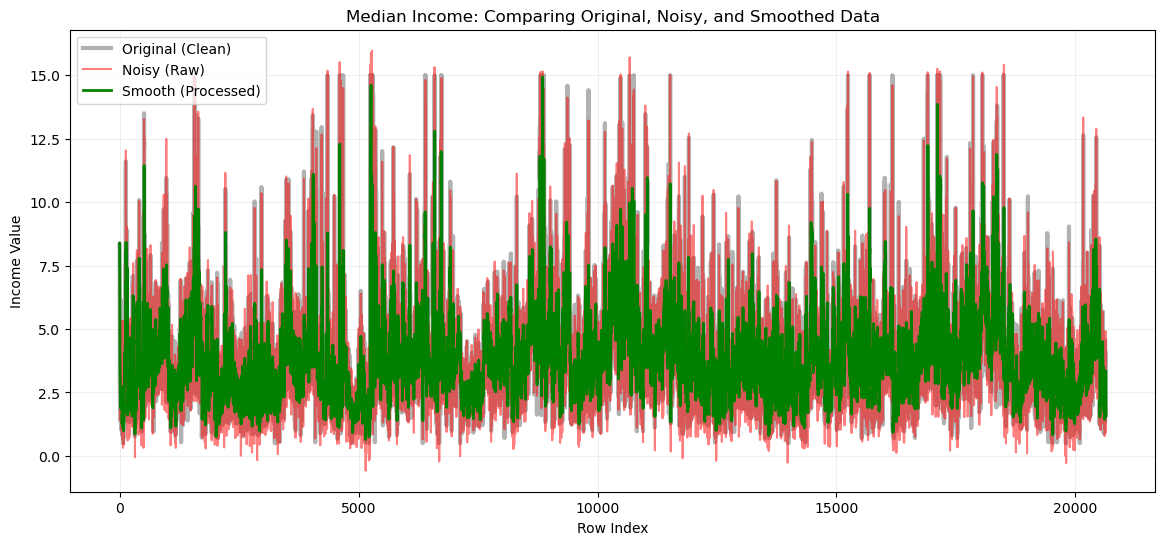

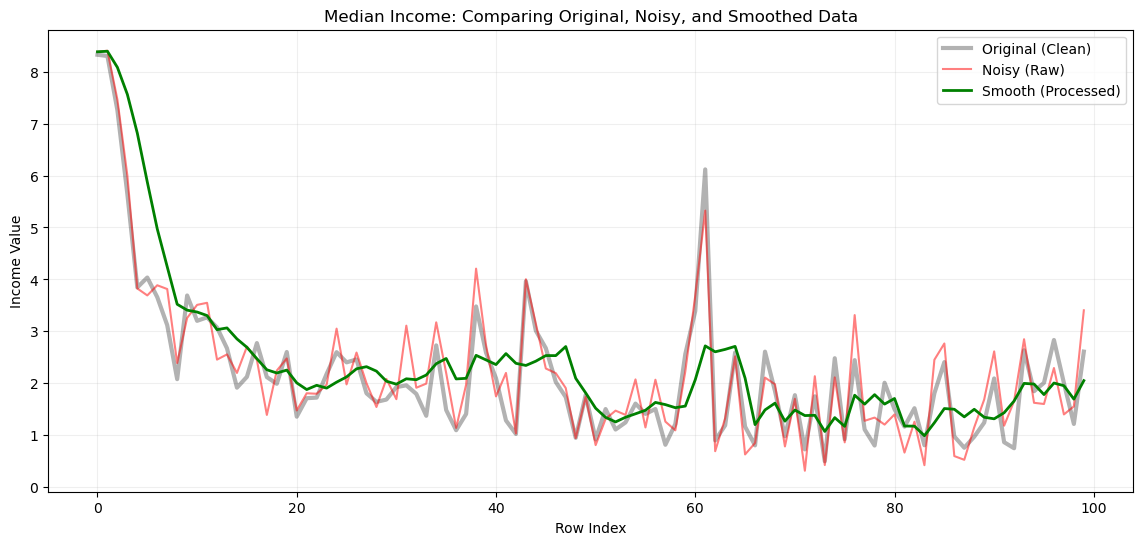

In [11]:
slice_df = X_processed

plt.figure(figsize=(14, 6))
plt.plot(slice_df['MedInc'], label='Original (Clean)', color='black', alpha=0.3, linewidth=3)
plt.plot(slice_df['MedInc_noisy'], label='Noisy (Raw)', color='red', alpha=0.5)
plt.plot(slice_df['MedInc_smooth'], label='Smooth (Processed)', color='green', linewidth=2)

plt.title("Median Income: Comparing Original, Noisy, and Smoothed Data")
plt.xlabel("Row Index")
plt.ylabel("Income Value")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# Just the first 100 rows of data to show the difference more clearly
slice_df = X_processed.iloc[:100]

plt.figure(figsize=(14, 6))
plt.plot(slice_df['MedInc'], label='Original (Clean)', color='black', alpha=0.3, linewidth=3)
plt.plot(slice_df['MedInc_noisy'], label='Noisy (Raw)', color='red', alpha=0.5)
plt.plot(slice_df['MedInc_smooth'], label='Smooth (Processed)', color='green', linewidth=2)

plt.title("Median Income: Comparing Original, Noisy, and Smoothed Data")
plt.xlabel("Row Index")
plt.ylabel("Income Value")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## Step 3: Outlier Detection and Handling

First the Z-score method is used to identify significant outliers witin the MedInc column.

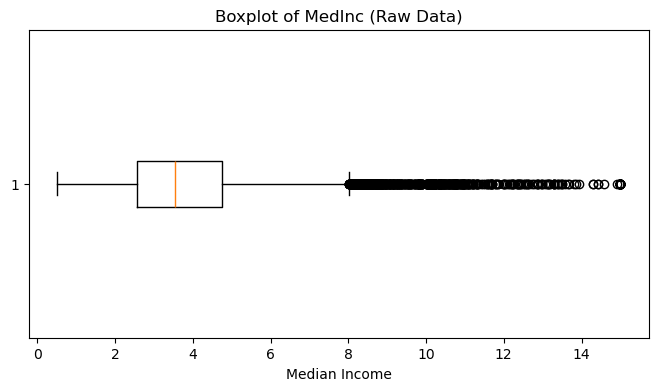

Number of outliers detected: 345


In [12]:
from scipy.stats import zscore

# A Z-score > 3 is the standard statistical threshold for 'extreme' outliers
z_scores = np.abs(zscore(X_processed['MedInc']))
X_processed['Is_Outlier'] = z_scores > 3

# Confirming the presence of outliers
plt.figure(figsize=(8, 4))
plt.boxplot(X_processed['MedInc'], vert=False)
plt.title("Boxplot of MedInc (Raw Data)")
plt.xlabel("Median Income")
plt.show()

print(f"Number of outliers detected: {X_processed['Is_Outlier'].sum()}")

The next step is to remove the outliers, as they do not represent the general housing market, but rather bias the model with high-income luxury areas which do not represent the average trend in the housing market.

Rows before removal: 20640
Rows after removal: 20295


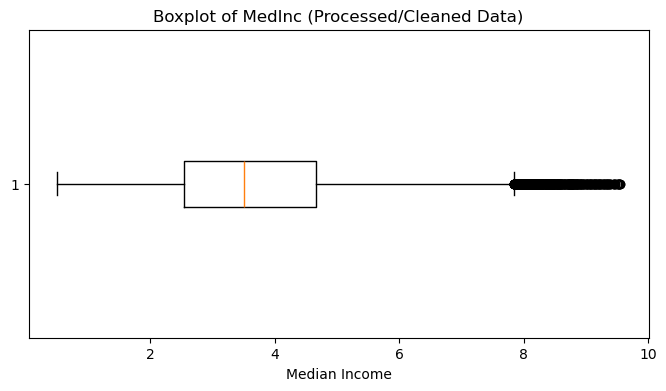

In [13]:
# Create a new dataframe excluding the outliers
X_cleaned = X_processed[X_processed['Is_Outlier'] == False].copy()

X_cleaned = X_cleaned.drop(columns=['Is_Outlier'])

print(f"Rows before removal: {len(X_processed)}")
print(f"Rows after removal: {len(X_cleaned)}")

# Final check of the distribution
plt.figure(figsize=(8, 4))
plt.boxplot(X_cleaned['MedInc'], vert=False)
plt.title("Boxplot of MedInc (Processed/Cleaned Data)")
plt.xlabel("Median Income")
plt.show()

## Step 4: Data Transformation

Feature Engineering and Binning will be demonstrated in this step. The California Housing dataset is purely numerical and therefore a "density" feature is an easy way to make the data more meaningful. The columns AveRooms and AveOccup will be used for this.

In [15]:
print("Raw features before transformation:")
display(X_cleaned[['AveRooms', 'HouseAge']].head())

# Creation new feature
X_cleaned['Rooms_per_Occupant'] = X_cleaned['AveRooms'] / X_cleaned['AveOccup']

print("New feature created:")
display(X_cleaned[['AveRooms', 'AveOccup', 'Rooms_per_Occupant']].head())

Raw features before transformation:


,AveRooms,HouseAge
0,6.984127,41.0
1,6.238137,21.0
2,8.288136,52.0
3,5.817352,52.0
4,6.281853,52.0


New feature created:


,AveRooms,AveOccup,Rooms_per_Occupant
0,6.984127,2.555556,2.732919
1,6.238137,2.109842,2.956685
2,8.288136,2.802260,2.957661
3,5.817352,2.547945,2.283154
4,6.281853,2.181467,2.879646


For the Binning the HouseAge column will be used. There will be three distinct groups: 'New', 'Old', 'Historic'. The problem that will be solved by transforming the data in this way is that the noise is reduced within the model because it groups similar ages together. This leads to the model not overfitting regarding to specific years. It instead focuses on the general 'era' the house was built in, which matters for its value.

In [18]:
# Define bins and labels for HouseAge
bins = [0, 15, 35, 100]
labels = ['New', 'Middle-Aged', 'Historic']

X_cleaned['Age_Category'] = pd.cut(X_cleaned['HouseAge'], bins=bins, labels=labels)

print("Binned feature (Age_Category):")
display(X_cleaned[['HouseAge', 'Age_Category']].head())

# Checking the distribution
print("Count of houses per category:")
print(X_cleaned['Age_Category'].value_counts())

Binned feature (Age_Category):


,HouseAge,Age_Category
0,41.0,Historic
1,21.0,Middle-Aged
2,52.0,Historic
3,52.0,Historic
4,52.0,Historic


Count of houses per category:
Age_Category
Middle-Aged    11797
Historic        5613
New             2885
Name: count, dtype: int64


## Step 5: Feature Scaling
The three features which will be used are: MedInc, HouseAge and AveRooms.

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Selecting 3 features with different original scales
features_to_scale = ['MedInc', 'HouseAge', 'AveRooms']
X_raw_subset = X_cleaned[features_to_scale].copy()

print("Original Data Statistics (Before Scaling):")
display(X_raw_subset.describe().loc[['min', 'max', 'mean', 'std']])

Original Data Statistics (Before Scaling):


,MedInc,HouseAge,AveRooms
min,0.499900,1.000000,0.846154
max,9.556100,52.000000,141.909091
mean,3.738741,28.669180,5.383215
std,1.604919,11.900161,2.460973


In [22]:
# 1. Z-Score scaling (Standardization)
scaler_std = StandardScaler()
X_standardized = pd.DataFrame(scaler_std.fit_transform(X_raw_subset), 
                              columns=features_to_scale, index=X_raw_subset.index)

# 2. Min-Max Scaling (Normalization)
scaler_minmax = MinMaxScaler()
X_normalized = pd.DataFrame(scaler_minmax.fit_transform(X_raw_subset), 
                            columns=features_to_scale, index=X_raw_subset.index)

# Display comparison for 'MedInc'
comparison_df = pd.DataFrame({
    'Original': X_raw_subset['MedInc'],
    'Standardized': X_standardized['MedInc'],
    'Normalized': X_normalized['MedInc']
})

print("Comparison of scaling methods on 'MedInc':")
display(comparison_df.head())

Comparison of scaling methods on 'MedInc':


,Original,Standardized,Normalized
0,8.3252,2.857822,0.864082
1,8.3014,2.842992,0.861454
2,7.2574,2.192476,0.746174
3,5.6431,1.186606,0.567920
4,3.8462,0.066958,0.369504


### When is Z-score / Min-Max scaling preferred?
The Z-score is used when Gaussian distribution or Linear Regression is usable. This prevents features with large variances from dominating. The Min-Max scaling is preferred for Neural Networks or K-Nearest Neighbors (KNN). Here it is crucial that all features are on the same scale, especially when data does not follow a normal distribution.